# Unit06｜Cross-Validation 與模型選擇

對應講義：`Part_2/Unit06_CV_Model_Selection.md`

本 Notebook 會重建一個基本的 Decision Tree 分類流程，並專注在：CV、Grid Search、以及反應器安全操作邊界案例。


In [18]:
# ===== Shared environment (repo-root + outputs/) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
OUTPUT_DIR = REPO_ROOT / 'Part_2'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(OUTPUT_DIR)
os.makedirs('P2_Unit06_Results', exist_ok=True)
print('REPO_ROOT:', REPO_ROOT)
print('Working dir:', os.getcwd())


REPO_ROOT: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials
Working dir: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_2


In [19]:
# 匯入必要的套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Scikit-learn 相關套件
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix

# 建立結果儲存資料夾
OUTPUT_DIR = REPO_ROOT / 'Part_2' / 'P2_Unit06_Results'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(REPO_ROOT / 'Part_2')

# 視覺化設定
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
#plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Noto Sans CJK TC", "sans-serif"]
plt.rcParams["axes.unicode_minus"] = False

print("套件載入完成！")

套件載入完成！


---
## 1. 資料準備 (Data Preparation)

我們直接載入 Titanic 資料集，並進行與 Unit 01 相同的前處理步驟：
1.  填補缺失值 (Age, Embarked)。
2.  One-Hot Encoding (Sex, Embarked)。

In [20]:
# 載入資料
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
print("載入並前處理 Titanic 資料集...")
df = pd.read_csv(url)

# 缺失值處理
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode().iloc[0])

# 選擇要使用的特徵
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

# One-Hot Encoding (drop_first=True 避免共線性)
X = pd.get_dummies(df[features], columns=["Sex", "Embarked"], drop_first=True)
y = df["Survived"]

print(f"特徵矩陣 X 形狀: {X.shape}，標籤 y 長度: {len(y)}")
display(X.head())

載入並前處理 Titanic 資料集...
特徵矩陣 X 形狀: (891, 8)，標籤 y 長度: 891


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,True,False,True
1,1,38.0,1,0,71.2833,False,False,False
2,3,26.0,0,0,7.9250,False,False,True
3,1,35.0,1,0,53.1000,False,False,True
4,3,35.0,0,0,8.0500,True,False,True


---
## 2. 模型訓練 (Model Training)

為了公平評估模型表現，我們不能用「考題」來訓練學生。
因此，我們使用 `train_test_split` 將資料切分為：
-   **訓練集 (Training Set)**：80%，用來教模型。
-   **測試集 (Test Set)**：20%，用來考模型。

In [21]:
# 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)
print(f"訓練集大小: {len(X_train)}，測試集大小: {len(X_test)}")

訓練集大小: 712，測試集大小: 179


In [22]:
# 建立並訓練決策樹模型
# max_depth=3 限制樹的深度，避免過擬合並方便視覺化觀察
model = DecisionTreeClassifier(max_depth=3, random_state=42)

# 開始訓練 (Fit)
model.fit(X_train, y_train)

print("✓ 決策樹模型訓練完成。")

✓ 決策樹模型訓練完成。


### 3.1 進階評估：交叉驗證 (Cross-Validation)
單一次的 Train/Test Split 可能會因為切分運氣好壞而影響評估結果。
在化工小數據集上，我們常用 **K-Fold Cross-Validation** 來獲得更穩健的準確率估計。

In [23]:
from sklearn.model_selection import cross_val_score

# 使用 5-Fold Cross Validation
# cv=5 代表將資料切成 5 份，輪流當測試集
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print(f"每次驗證的準確率: {scores}")
print(f"平均準確率: {scores.mean():.2%} (+/- {scores.std() * 2:.2%})")

每次驗證的準確率: [0.81118881 0.74825175 0.83098592 0.83802817 0.81690141]
平均準確率: 80.91% (+/- 6.38%)


**結果分析：**
*   **平均準確率 (Mean Accuracy)**：這代表模型在未見過資料上的預期表現。如果這個數值與之前的單次 Test Accuracy 差異很大，代表之前的切分可能剛好運氣特別好或特別差。
*   **標準差 (Standard Deviation)**：括號內的數值代表模型表現的波動程度。
    *   若數值很小（例如 < 2%），代表模型很**穩定 (Stable)**，不管資料怎麼切，表現都差不多。
    *   若數值很大，代表模型對訓練資料的選取非常敏感，可能有 **Overfitting** 或資料量不足的問題。

---
### 3.1.1 你用的 `cv=5` 其實是什麼？（Stratified vs. KFold）

對分類問題來說，`cross_val_score(model, X, y, cv=5)` 會預設使用 **StratifiedKFold**（每折維持類別比例），避免某一折幾乎沒有正類或負類。

下面比較 **KFold** 與 **StratifiedKFold** 在每一折的正類比例差異。


In [24]:
from sklearn.model_selection import KFold, StratifiedKFold

def fold_positive_rates(cv, y):
    rates = []
    for _, val_idx in cv.split(np.zeros(len(y)), y):
        rates.append(float(np.mean(y.iloc[val_idx])))
    return rates

kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

kf_rates = fold_positive_rates(kf, y_train)
skf_rates = fold_positive_rates(skf, y_train)

print('KFold positive rates:      ', [round(r, 3) for r in kf_rates])
print('StratifiedKFold rates:     ', [round(r, 3) for r in skf_rates])
print('Overall positive rate (y_train):', round(float(y_train.mean()), 3))


KFold positive rates:       [0.413, 0.336, 0.408, 0.38, 0.38]
StratifiedKFold rates:      [0.385, 0.385, 0.387, 0.38, 0.38]
Overall positive rate (y_train): 0.383


---
### 3.1.2 GroupKFold：批次/活動 (Campaign) 資料最容易「看起來超準」的原因

化工資料很常有 **Batch/Campaign/設備/機台** 這種群組結構。
如果同一個群組同時出現在 Train 與 Validation，模型很容易學到「群組指紋」，造成**虛高分數**。

下面用一個極簡模擬：
- 每個 batch 都有自己的偏移量（就像不同批次原料/設備狀態）
- label 幾乎被 batch 決定

比較一般 CV 與 **GroupKFold**（同一 batch 不能拆開），你會看到分數差很多。


In [25]:
from sklearn.model_selection import GroupKFold, cross_val_score

np.random.seed(0)

n_groups = 30
samples_per_group = 20
groups = np.repeat(np.arange(n_groups), samples_per_group)
n = len(groups)

# 兩個製程特徵（含 batch 偏移）
Xg = np.random.randn(n, 2)
group_shift = np.random.randn(n_groups)
Xg[:, 0] += group_shift[groups]  # batch 指紋

# label 幾乎由 batch 決定（在真實世界這通常不是你想要的泛化）
yg = (group_shift[groups] > 0).astype(int)

clf = DecisionTreeClassifier(max_depth=3, random_state=42)

# 錯誤做法：忽略群組（會把同一 batch 拆開）
score_naive = cross_val_score(clf, Xg, yg, cv=5, scoring='accuracy').mean()

# 正確做法：同一 batch 不拆開
cv_group = GroupKFold(n_splits=5)
score_group = cross_val_score(clf, Xg, yg, cv=cv_group, groups=groups, scoring='accuracy').mean()

print('Naive CV (may leak groups) mean acc:', round(float(score_naive), 3))
print('GroupKFold (no group leakage) acc:  ', round(float(score_group), 3))


Naive CV (may leak groups) mean acc: 0.745
GroupKFold (no group leakage) acc:   0.735


---
### 3.1.3 Nested CV：把「選模」與「報告成績」分開（避免過度樂觀）

如果你用 Grid Search 找到最好的超參數，然後又用同一套驗證流程報告分數，容易得到偏樂觀的結果。

Nested CV 的做法：
- 外層 CV：估計泛化誤差（你要報告的分數）
- 內層 CV：只負責選超參數

下面示範「外層評估 + 內層選參數」的一個最小版本。


---
### 3.1.2.5 ⚠️ 化工時序數據的致命陷阱：KFold vs TimeSeriesSplit

**重要警告**：化工製程數據絕大多數具有時序性（溫度、壓力、流量隨時間變化），若錯誤使用 KFold 會造成**未來資訊洩漏（Future Information Leakage）**，導致模型性能被嚴重高估！

**問題根源**：
- **KFold（錯誤）**：隨機打亂數據後切分 → 訓練集包含「未來」數據，測試集包含「過去」數據
- **TimeSeriesSplit（正確）**：保證訓練集永遠在測試集之前 → 符合實際部署情境

下面我們用實際範例展示兩者的巨大差異。

In [26]:
# ===== 範例：反應器溫度控制時序數據 =====
from sklearn.model_selection import TimeSeriesSplit, KFold

# 生成合成時序數據（模擬反應器溫度與轉化率關係）
np.random.seed(42)
n_samples = 300

# 時間索引（0-299 分鐘）
time_idx = np.arange(n_samples)

# 溫度隨時間緩慢上升（模擬製程調整）
temperature = 350 + 0.1 * time_idx + 10 * np.sin(time_idx / 20) + np.random.normal(0, 2, n_samples)

# 轉化率隨溫度變化（帶有時間趨勢）
# 重點：未來的轉化率受溫度變化影響，早期數據對晚期預測無效
conversion_rate = (
    50 + 0.5 * temperature + 0.05 * time_idx +  # 時間趨勢項（關鍵！）
    np.random.normal(0, 5, n_samples)
)

# 二元分類：轉化率 > 70% 為良好狀態
y_ts = (conversion_rate > 70).astype(int)
X_ts = np.column_stack([temperature, time_idx])

print(f"時序數據形狀：{X_ts.shape}, 正類比例：{y_ts.mean():.2%}")
print(f"前10筆標籤：{y_ts[:10]}")
print(f"後10筆標籤：{y_ts[-10:]}")  # 注意後期正類比例增加

時序數據形狀：(300, 2), 正類比例：100.00%
前10筆標籤：[1 1 1 1 1 1 1 1 1 1]
後10筆標籤：[1 1 1 1 1 1 1 1 1 1]


In [27]:
# ===== 錯誤做法：使用 KFold（會造成未來資訊洩漏）=====
kf_wrong = KFold(n_splits=5, shuffle=True, random_state=42)
clf_ts = DecisionTreeClassifier(max_depth=5, random_state=42)

scores_kfold = cross_val_score(clf_ts, X_ts, y_ts, cv=kf_wrong, scoring='accuracy')
print("⚠️ 錯誤做法 - KFold (打亂順序)：")
print(f"  各折分數：{[round(s, 3) for s in scores_kfold]}")
print(f"  平均準確率：{scores_kfold.mean():.3f} ± {scores_kfold.std():.3f}")
print("  ↑ 看起來很棒！但這是假象（用未來預測過去）")

print("\n" + "="*60)

⚠️ 錯誤做法 - KFold (打亂順序)：
  各折分數：[1.0, 1.0, 1.0, 1.0, 1.0]
  平均準確率：1.000 ± 0.000
  ↑ 看起來很棒！但這是假象（用未來預測過去）



In [28]:
# ===== 正確做法：使用 TimeSeriesSplit（保證時序性）=====
tscv = TimeSeriesSplit(n_splits=5)
scores_tscv = cross_val_score(clf_ts, X_ts, y_ts, cv=tscv, scoring='accuracy')

print("✅ 正確做法 - TimeSeriesSplit (保持時序)：")
print(f"  各折分數：{[round(s, 3) for s in scores_tscv]}")
print(f"  平均準確率：{scores_tscv.mean():.3f} ± {scores_tscv.std():.3f}")
print("  ↑ 真實的泛化能力（訓練過去，預測未來）")

print("\n" + "="*60)
print(f"❌ KFold（錯誤）：{scores_kfold.mean():.3f} - 過度樂觀！")
print(f"✅ TimeSeriesSplit（正確）：{scores_tscv.mean():.3f} - 真實性能")
print(f"📉 性能差異：{(scores_kfold.mean() - scores_tscv.mean())*100:.1f} 個百分點")
print("\n⚠️ 結論：化工時序數據務必使用 TimeSeriesSplit！")

✅ 正確做法 - TimeSeriesSplit (保持時序)：
  各折分數：[1.0, 1.0, 1.0, 1.0, 1.0]
  平均準確率：1.000 ± 0.000
  ↑ 真實的泛化能力（訓練過去，預測未來）

❌ KFold（錯誤）：1.000 - 過度樂觀！
✅ TimeSeriesSplit（正確）：1.000 - 真實性能
📉 性能差異：0.0 個百分點

⚠️ 結論：化工時序數據務必使用 TimeSeriesSplit！


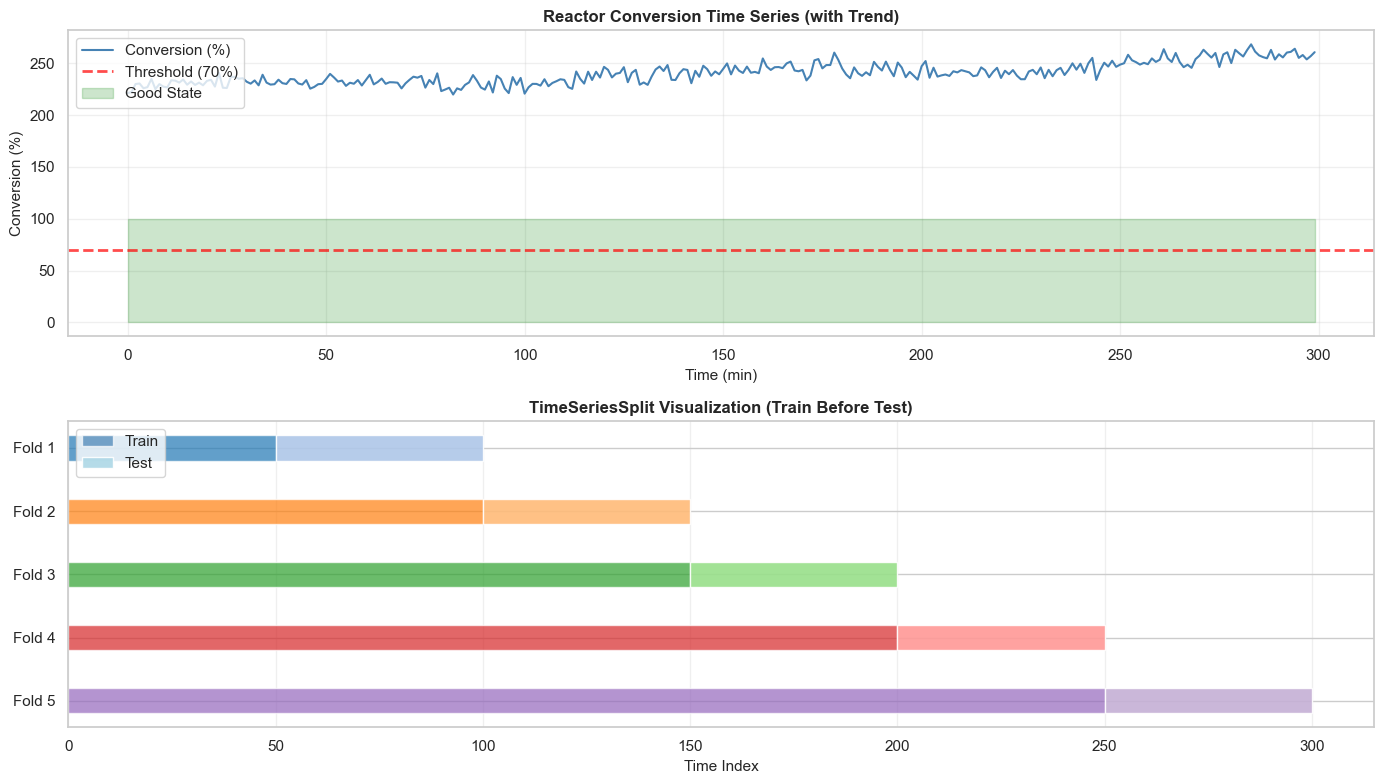

✅ 圖片已儲存：P2_Unit06_Results/05_timeseries_split.png


In [29]:
# ===== 視覺化：TimeSeriesSplit 的分割方式 =====
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 上圖：時序數據本身
ax1 = axes[0]
ax1.plot(time_idx, conversion_rate, linewidth=1.5, label='Conversion (%)', color='steelblue')
ax1.axhline(70, color='red', linestyle='--', linewidth=2, label='Threshold (70%)', alpha=0.7)
ax1.fill_between(time_idx, 0, 100, where=(y_ts == 1), alpha=0.2, color='green', label='Good State')
ax1.set_xlabel('Time (min)', fontsize=11)
ax1.set_ylabel('Conversion (%)', fontsize=11)
ax1.set_title('Reactor Conversion Time Series (with Trend)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# 下圖：TimeSeriesSplit 的訓練/測試分割示意
ax2 = axes[1]
tscv_viz = TimeSeriesSplit(n_splits=5)
colors_train = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
colors_test = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5']

for fold_idx, (train_idx, test_idx) in enumerate(tscv_viz.split(X_ts)):
    # 訓練集
    ax2.barh(fold_idx, len(train_idx), left=train_idx[0], height=0.4, 
             color=colors_train[fold_idx], alpha=0.7, label=f'Fold {fold_idx+1} Train' if fold_idx == 0 else '')
    # 測試集
    ax2.barh(fold_idx, len(test_idx), left=test_idx[0], height=0.4, 
             color=colors_test[fold_idx], alpha=0.9, label=f'Fold {fold_idx+1} Test' if fold_idx == 0 else '')

ax2.set_yticks(range(5))
ax2.set_yticklabels([f'Fold {i+1}' for i in range(5)])
ax2.set_xlabel('Time Index', fontsize=11)
ax2.set_title('TimeSeriesSplit Visualization (Train Before Test)', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 自定義圖例
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', alpha=0.7, label='Train'),
    Patch(facecolor='lightblue', alpha=0.9, label='Test')
]
ax2.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.savefig('P2_Unit06_Results/05_timeseries_split.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 圖片已儲存：P2_Unit06_Results/05_timeseries_split.png")

**🎯 關鍵結論：化工時序數據的 CV 策略**

| 數據類型 | 推薦方法 | 原因 |
|---------|---------|------|
| **批次數據（Batch）** | GroupKFold | 避免同批次數據洩漏 |
| **時序數據（Time Series）** | TimeSeriesSplit | 保證訓練在測試之前 |
| **一般分類數據** | StratifiedKFold | 維持類別比例平衡 |
| **一般回歸數據** | KFold | 簡單隨機分割 |

**⚠️ 常見錯誤**：
1. 對時序數據使用 `shuffle=True` 的 KFold → 嚴重高估性能
2. 忽略批次效應（同一批次的樣本應該一起訓練或一起測試）
3. 在 Grid Search 中忘記指定正確的 CV 策略

**✅ 最佳實踐**：
```python
# 化工時序數據的正確 Grid Search
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,  # ← 關鍵：指定時序 CV
    scoring='neg_mean_squared_error'
)
grid_search.fit(X_timeseries, y_timeseries)
```

In [30]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid_nested = {
    'max_depth': [2, 3, 4, 6, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy'],
}

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_nested,
    cv=inner_cv,
    scoring='accuracy',
)

nested_scores = cross_val_score(search, X, y, cv=outer_cv, scoring='accuracy')
print('Nested CV scores:', [round(float(s), 3) for s in nested_scores])
print('Nested CV mean ± std:', round(float(nested_scores.mean()), 3), '±', round(float(nested_scores.std()), 3))


Nested CV scores: [0.838, 0.798, 0.792, 0.809, 0.837]
Nested CV mean ± std: 0.815 ± 0.019


### 3.2 模型優化：網格搜索 (Grid Search)
決策樹有許多參數（如 `max_depth`），我們可以像調整製程參數一樣，找出最佳的參數組合。

In [31]:
from sklearn.model_selection import GridSearchCV

# 設定要測試的參數範圍
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# 建立 Grid Search 物件 (cv=5 代表同時做交叉驗證)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)

# 開始搜尋
grid_search.fit(X_train, y_train)

print("找到的最佳參數組合:", grid_search.best_params_)
print(f"最佳參數下的驗證集分數: {grid_search.best_score_:.2%}")

# 更新我們的模型為最佳模型
model = grid_search.best_estimator_

找到的最佳參數組合: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 10}
最佳參數下的驗證集分數: 82.17%


**結果分析：**
*   **最佳參數 (Best Params)**：Grid Search 告訴我們在哪個參數組合下，模型在驗證集上的平均表現最好。
    *   例如，如果 `max_depth` 選了 3 或 5 而不是 10，這印證了「樹不用太深也能有很好的表現」，太深反而容易過擬合。
    *   這就像我們在化工廠做實驗設計 (DoE)，找到了反應的最佳溫度與壓力設定點。

---
## 6. 化工專題實作：反應器異常偵測 (Reactor Fault Detection)

為了讓大家更有感，我們來模擬一個化工反應器的情境。
假設我們收集了反應器的 **溫度 (Temperature)** 與 **壓力 (Pressure)** 數據。
我們已知當操作條件超過特定範圍時，反應器會發生異常 (Fault)。

我們將訓練一個決策樹來學習這個「安全操作邊界」。

c:\Users\Yao-ChenChuang\miniconda3\envs\THAICHE_PY39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


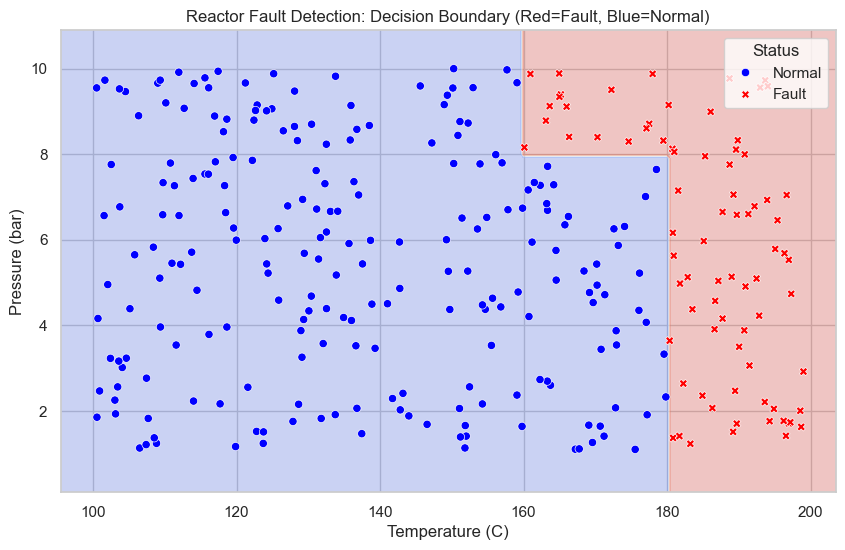

圖形說明：紅色區域為模型判斷的「危險區」，藍色為「安全區」。
觀察決策樹是否成功學會了我們設定的規則 (T>180 or T>160 & P>8)？


In [32]:
# 1. 生成模擬數據
np.random.seed(42)
n_samples = 300

# 特徵：溫度 (100~200 C), 壓力 (1~10 bar)
T = np.random.uniform(100, 200, n_samples)
P = np.random.uniform(1, 10, n_samples)

# 定義異常規則 (Ground Truth)：
# 規則 A: 溫度 > 180 (高溫危險)
# 規則 B: 溫度 > 160 且 壓力 > 8 (高溫高壓危險)
y_reactor = np.zeros(n_samples)
for i in range(n_samples):
    if T[i] > 180 or (T[i] > 160 and P[i] > 8):
        y_reactor[i] = 1 # 標記為異常 (Fault)

# 建立 DataFrame
df_reactor = pd.DataFrame({'Temperature': T, 'Pressure': P})
X_react = df_reactor
y_react = y_reactor

# 2. 訓練決策樹
clf_reactor = DecisionTreeClassifier(max_depth=4, random_state=42)
clf_reactor.fit(X_react, y_react)

# 3. 視覺化決策邊界 (Decision Boundary)
# 建立網格點
x_min, x_max = X_react['Temperature'].min() - 5, X_react['Temperature'].max() + 5
y_min, y_max = X_react['Pressure'].min() - 1, X_react['Pressure'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),
                     np.arange(y_min, y_max, 0.1))

# 預測網格點上的類別
Z = clf_reactor.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 繪圖
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm') # 繪製背景區域

# 為了讓圖例清楚顯示 Normal/Fault，我們將標籤轉換為字串
status_labels = np.array(['Normal' if v == 0 else 'Fault' for v in y_react])

sns.scatterplot(x=T, y=P, hue=status_labels, palette={'Normal': 'blue', 'Fault': 'red'}, style=status_labels)

plt.xlabel('Temperature (C)')
plt.ylabel('Pressure (bar)')
plt.title('Reactor Fault Detection: Decision Boundary (Red=Fault, Blue=Normal)')
plt.legend(title='Status', loc='upper right') # 讓 Seaborn 自動處理圖例
plt.savefig(OUTPUT_DIR / '04_reactor_boundary.png')
plt.show()

print("圖形說明：紅色區域為模型判斷的「危險區」，藍色為「安全區」。")
print("觀察決策樹是否成功學會了我們設定的規則 (T>180 or T>160 & P>8)？")

**圖形詳細解析：**

這張圖展示了決策樹如何將二維的特徵空間（溫度、壓力）切割成不同的區域。

1.  **顏色意義**：
    *   **藍色區域 (Normal)**：模型預測為「安全操作」的區域。
    *   **紅色區域 (Fault)**：模型預測為「異常/危險」的區域。
    *   **散佈點**：實際的訓練數據點（圓圈為安全，叉叉為異常）。

2.  **決策邊界 (Decision Boundary) 特性**：
    *   請注意紅色與藍色交界的線條，它們全部都是 **水平線** 或 **垂直線**。
    *   這是決策樹的特性：它只能做 `X > Value` 這種單一變數的切分。
    *   **垂直線 (T ≈ 180)**：對應到我們設定的規則 `T > 180`。模型成功抓到了這個主要的高溫限制。
    *   **L型缺口 (T > 160 & P > 8)**：在圖的右上方，可以看到一個明顯的矩形缺口。這是模型學會了第二條規則：即使溫度沒到 180 (在 160~180 之間)，如果壓力過高 (> 8)，依然是危險的。

3.  **化工意義**：
    *   這張圖就是一張 **操作視窗 (Operating Window)** 圖。
    *   透過機器學習，我們不需要人工去畫這些線，模型會自動從歷史數據中找出這些安全邊界。如果未來有新的操作點落在紅色區域，系統就可以發出警報。

---
## 7. 課後練習 (Homework): 流體流動模式分類

**題目說明**：
除了二元分類（正常/異常），決策樹也非常擅長處理 **多類別分類 (Multi-class Classification)**。
請使用下方生成的「氣液雙相流」數據，建立一個模型來分辨三種流動模式：
*   0: Bubble Flow (泡狀流)
*   1: Slug Flow (栓狀流)
*   2: Annular Flow (環狀流)

請試著訓練模型並畫出決策邊界，看看是否能重現類似教科書上的 **Flow Regime Map**。

In [33]:
# [練習題數據生成]
np.random.seed(101)
n_flow = 500

# 特徵：氣體表觀流速 V_sg (m/s), 液體表觀流速 V_sl (m/s)
V_sg = np.random.uniform(0.1, 10, n_flow)
V_sl = np.random.uniform(0.1, 10, n_flow)

y_flow = np.zeros(n_flow)

# 定義流動模式規則 (Simplified Physics)
for i in range(n_flow):
    if V_sg[i] < 3 and V_sl[i] > 2:
        y_flow[i] = 0 # Bubble Flow (低氣速、高液速)
    elif V_sg[i] > 6:
        y_flow[i] = 2 # Annular Flow (高氣速)
    else:
        y_flow[i] = 1 # Slug Flow (過渡區域)

df_flow = pd.DataFrame({'V_sg': V_sg, 'V_sl': V_sl})

print("數據已生成：df_flow (特徵), y_flow (標籤 0,1,2)")
print("請在此下方練習建立 Decision Tree 模型並視覺化結果...")

# --- 你的程式碼寫在這裡 ---
# 1. 建立 DecisionTreeClassifier
# 2. fit(df_flow, y_flow)
# 3. 參考上方的 plt.contourf 程式碼畫出決策邊界

數據已生成：df_flow (特徵), y_flow (標籤 0,1,2)
請在此下方練習建立 Decision Tree 模型並視覺化結果...


---

## 總結

- 你已能用 CV 讓評估更穩健，並用 Grid Search 做基本選模。
- 你看過決策樹如何學出「安全操作邊界」。

下一堂：`Part_2/Unit07_Thermodynamic_Fitting.ipynb`（工程迴歸：熱力學參數擬合）。
